# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [29]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [30]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [213]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [50]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, lr_sched=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if lr_sched: lr_sched.step()        
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()            
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation model.py
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    n_correct = 0
    n_total = 0
    
    for x, y in loader:
        batch_pred = model(x).argmax(1)
        n_correct += (batch_pred == y).nonzero().size(0)
        n_total += y.size(0)
            
    return n_correct / n_total

In [214]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.822303, Train accuracy: 0.410146, Val accuracy: 0.554228
Average loss: 1.463348, Train accuracy: 0.577722, Val accuracy: 0.592929
Average loss: 1.384164, Train accuracy: 0.614357, Val accuracy: 0.622415
Average loss: 1.352864, Train accuracy: 0.632734, Val accuracy: 0.623029
Average loss: 1.336926, Train accuracy: 0.639969, Val accuracy: 0.647055
Average loss: 1.329522, Train accuracy: 0.645616, Val accuracy: 0.648079
Average loss: 1.322028, Train accuracy: 0.649319, Val accuracy: 0.639137
Average loss: 1.319045, Train accuracy: 0.650684, Val accuracy: 0.647942
Average loss: 1.316895, Train accuracy: 0.651793, Val accuracy: 0.645417
Average loss: 1.315002, Train accuracy: 0.653841, Val accuracy: 0.654017


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [56]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 100),
             nn.ReLU(inplace=True),
             nn.Linear(100, 100),
             nn.ReLU(inplace=True),
             nn.Linear(100, 10),     
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.186664, Train accuracy: 0.189042, Val accuracy: 0.197324
Average loss: 1.999682, Train accuracy: 0.272515, Val accuracy: 0.360317
Average loss: 1.780553, Train accuracy: 0.390131, Val accuracy: 0.396423
Average loss: 1.701753, Train accuracy: 0.422312, Val accuracy: 0.420790
Average loss: 1.676582, Train accuracy: 0.437071, Val accuracy: 0.438127


Добавьте слой с Batch Normalization

In [54]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 100),
             nn.BatchNorm1d(100),
             nn.ReLU(inplace=True),
             nn.Linear(100, 100),
             nn.BatchNorm1d(100),    
             nn.ReLU(inplace=True),
             nn.Linear(100, 10),
         )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.924385, Train accuracy: 0.375235, Val accuracy: 0.355061
Average loss: 1.771985, Train accuracy: 0.452957, Val accuracy: 0.472664
Average loss: 1.768296, Train accuracy: 0.452752, Val accuracy: 0.438264
Average loss: 1.765998, Train accuracy: 0.450039, Val accuracy: 0.472527
Average loss: 1.755368, Train accuracy: 0.451814, Val accuracy: 0.333629


Добавьте уменьшение скорости обучения по ходу тренировки.

In [57]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 100),
             nn.BatchNorm1d(100),
             nn.ReLU(inplace=True),
             nn.Linear(100, 100),
             nn.BatchNorm1d(100),    
             nn.ReLU(inplace=True),
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, lr_sched=lr_sched)


Average loss: 1.938259, Train accuracy: 0.358632, Val accuracy: 0.397311
Average loss: 1.779067, Train accuracy: 0.427465, Val accuracy: 0.450208
Average loss: 1.737336, Train accuracy: 0.458298, Val accuracy: 0.460446
Average loss: 1.728827, Train accuracy: 0.459936, Val accuracy: 0.444611
Average loss: 1.685920, Train accuracy: 0.485360, Val accuracy: 0.458194


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [257]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    sampler = SubsetSampler(indices)
    predictions = []
    ground_truth = []
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    
    for x,y in loader:
        predictions += model(x).argmax(1).tolist()
        ground_truth += y.tolist()

    return np.array(predictions), np.array(ground_truth)

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

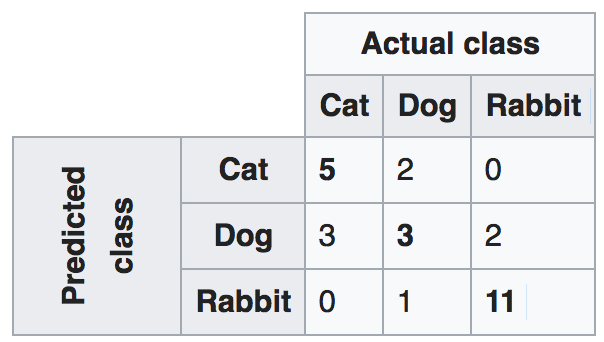

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

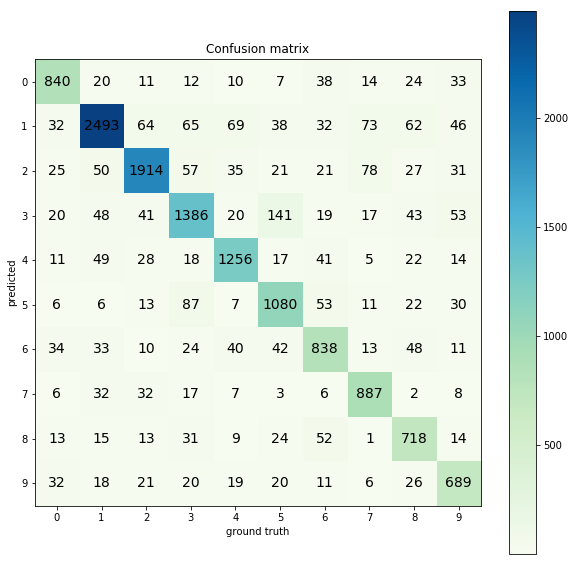

In [258]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[pred][gt] += 1
    
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

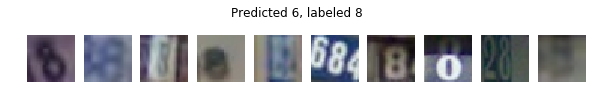

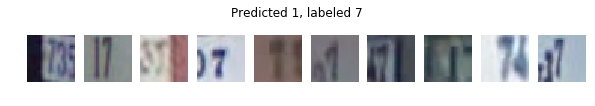

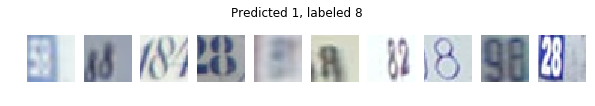

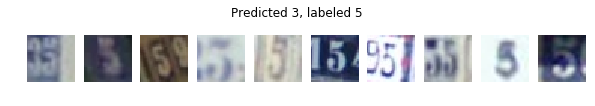

In [260]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    visualize_images(val_indices[np.arange(gt.shape[0])[(predictions == predicted_class) & (gt == gt_class)]], data,
                     f"Predicted {predicted_class}, labeled {gt_class}")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [243]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 100),
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 100),    
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, lr_sched=lr_sched)

Average loss: 1.792790, Train accuracy: 0.446627, Val accuracy: 0.485291
Average loss: 1.592394, Train accuracy: 0.546565, Val accuracy: 0.594362
Average loss: 1.514029, Train accuracy: 0.591578, Val accuracy: 0.581667
Average loss: 1.490822, Train accuracy: 0.599034, Val accuracy: 0.637909
Average loss: 1.407913, Train accuracy: 0.645958, Val accuracy: 0.665552


In [245]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 200),
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(200),    
             nn.Linear(200, 100),    
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, lr_sched=lr_sched)

Average loss: 1.747609, Train accuracy: 0.477408, Val accuracy: 0.544263
Average loss: 1.558474, Train accuracy: 0.563116, Val accuracy: 0.590062
Average loss: 1.477907, Train accuracy: 0.612855, Val accuracy: 0.598457
Average loss: 1.456136, Train accuracy: 0.619732, Val accuracy: 0.605488
Average loss: 1.366761, Train accuracy: 0.670102, Val accuracy: 0.677019


In [253]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 200),
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(200),    
             nn.Linear(200, 100),    
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, lr_sched=lr_sched)

Average loss: 1.740859, Train accuracy: 0.474508, Val accuracy: 0.559074
Average loss: 1.552656, Train accuracy: 0.565113, Val accuracy: 0.573681
Average loss: 1.466214, Train accuracy: 0.617189, Val accuracy: 0.608559
Average loss: 1.444343, Train accuracy: 0.623639, Val accuracy: 0.620504
Average loss: 1.353635, Train accuracy: 0.672696, Val accuracy: 0.676746
Average loss: 1.333946, Train accuracy: 0.673225, Val accuracy: 0.676677
Average loss: 1.270524, Train accuracy: 0.706890, Val accuracy: 0.725411
Average loss: 1.257350, Train accuracy: 0.708938, Val accuracy: 0.726708
Average loss: 1.215888, Train accuracy: 0.731802, Val accuracy: 0.730803
Average loss: 1.205990, Train accuracy: 0.733867, Val accuracy: 0.738994


In [247]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 200),
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(200),    
             nn.Linear(200, 100),    
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5, lr_sched=lr_sched)

Average loss: 1.504337, Train accuracy: 0.533102, Val accuracy: 0.661866
Average loss: 1.030010, Train accuracy: 0.683804, Val accuracy: 0.711965
Average loss: 0.813801, Train accuracy: 0.750947, Val accuracy: 0.761859
Average loss: 0.757218, Train accuracy: 0.768300, Val accuracy: 0.767524
Average loss: 0.661366, Train accuracy: 0.798212, Val accuracy: 0.799741


In [255]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
             Flattener(),
             nn.Linear(3*32*32, 200),
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(200),    
             nn.Linear(200, 100),    
             nn.ReLU(inplace=True),
             nn.BatchNorm1d(100),    
             nn.Linear(100, 10),
         )

nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-3)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10, lr_sched=lr_sched)

Average loss: 1.555856, Train accuracy: 0.508259, Val accuracy: 0.620299
Average loss: 1.056853, Train accuracy: 0.677115, Val accuracy: 0.692239
Average loss: 0.880957, Train accuracy: 0.726820, Val accuracy: 0.695379
Average loss: 0.793147, Train accuracy: 0.754854, Val accuracy: 0.765135
Average loss: 0.721642, Train accuracy: 0.777736, Val accuracy: 0.799945
Average loss: 0.670375, Train accuracy: 0.793895, Val accuracy: 0.791618
Average loss: 0.633671, Train accuracy: 0.805634, Val accuracy: 0.807726
Average loss: 0.597166, Train accuracy: 0.817510, Val accuracy: 0.814620
Average loss: 0.573272, Train accuracy: 0.824455, Val accuracy: 0.813050
Average loss: 0.548254, Train accuracy: 0.832321, Val accuracy: 0.825950


In [256]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7972
